In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets as ds, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from scipy.spatial.distance import cdist

<h2>DATA PREPS</h2>

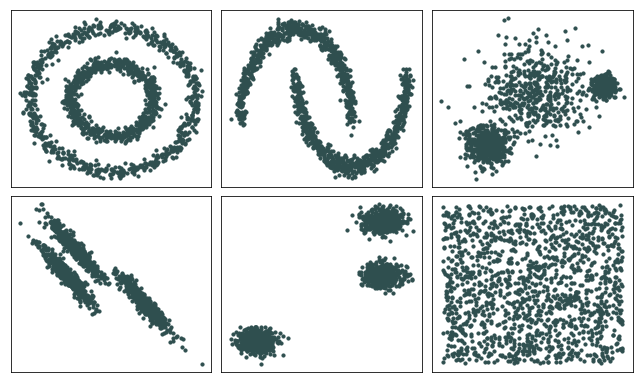

In [2]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles,_ = ds.make_circles(n_samples=n_samples,factor=.5,noise=.05)
noisy_moons,_ = ds.make_moons(n_samples=n_samples,noise=.05)
blobs,_ = ds.make_blobs(n_samples=n_samples,random_state=8)
no_structure,_ = np.random.rand(n_samples, 2),None

# Anisotropicly distributed data
random_state = 170
X,y = ds.make_blobs(n_samples=n_samples,random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso,_ = (X_aniso, y)

# blobs with varied variances
varied,_= ds.make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9, 16))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.05)
plot_num = 1

datasets=[noisy_circles,noisy_moons,varied,aniso,blobs,no_structure]

for data in datasets:
    plt.subplot(len(datasets), 3, plot_num)
    plt.scatter(data[:,0],data[:, 1],s=10,color="#2F4F4F")
    plt.xticks(())
    plt.yticks(())
    plot_num += 1
plt.show()

<h2>HIERARCHICAL CLUSTERING</h2>

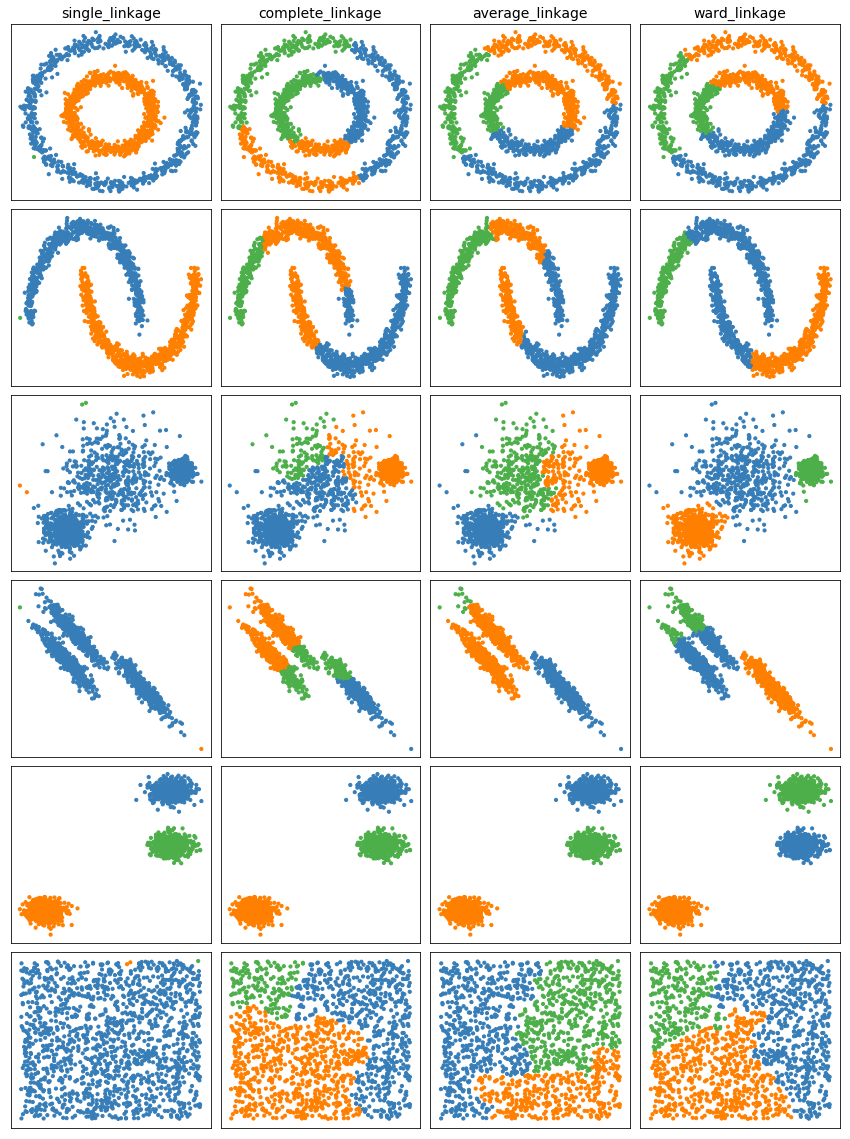

In [3]:
plt.figure(figsize=(12,16))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.05)
plot_num = 1

single_link_algo=(cluster.AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    compute_full_tree=True,
    linkage='single',
),"single_linkage")
complete_link_algo=(cluster.AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    compute_full_tree=True,
    linkage='complete',
),"complete_linkage")
average_link_algo=(cluster.AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    compute_full_tree=True,
    linkage='average',
),"average_linkage")
ward_link_algo=(cluster.AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    compute_full_tree=True,
    linkage='ward',
),"ward_linkage")

algorithms=[single_link_algo,complete_link_algo,average_link_algo,ward_link_algo]

for data in datasets:
    for algo in algorithms:
        algo_inst,algo_name=algo
        clustering=algo_inst.fit(data)
        y_pred=clustering.labels_.astype(np.int)
        plt.subplot(len(datasets),len(algorithms),plot_num)
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        if plot_num<=len(algorithms):
            plt.title(algo_name, size=14)
        plt.scatter(data[:,0],data[:,1],s=10,color=colors[y_pred])
        plt.xticks(())
        plt.yticks(())
        plot_num+=1
plt.show()

<h2>KMEANS CLUSTERING</h2>

In [5]:
def tuning_kmeans(
        data,
        stop_threshold=0.1,
        niters=15,
        plot=True,
    ):
    """
    @param data: data to be fitted in K-means models
    @param stop_threshold: stopping criteria based on improvement 
        in objective function values
        default=0.1
    @param niters: number of iterations varying different values of K
        default=15
    @param plot: whether to plot the objective function curve 
    """
    nclusters=1
    distortions=[]
    Ks=[]
    ypreds=[]
    for i in range(niters):
        clustering=cluster.KMeans(n_clusters=nclusters).fit(data)
        y_pred=clustering.labels_.astype(np.int)
        centroids=clustering.cluster_centers_
        distortions.append(
            sum(np.min(cdist(data,centroids,"euclidean"),axis=1))/data.shape[0]
        )
        Ks.append(nclusters)
        ypreds.append(y_pred)
        nclusters+=1
    # find recommendation
    recI=-1
    for i,val in enumerate(distortions):
        if i==len(distortions)-1:
            break
        if val-distortions[i+1]<stop_threshold*val:
            recI=i
            break
    if recI==-1:
        print("[Warning] No threshold found")
    return Ks[recI],ypreds[recI],Ks,distortions,recI

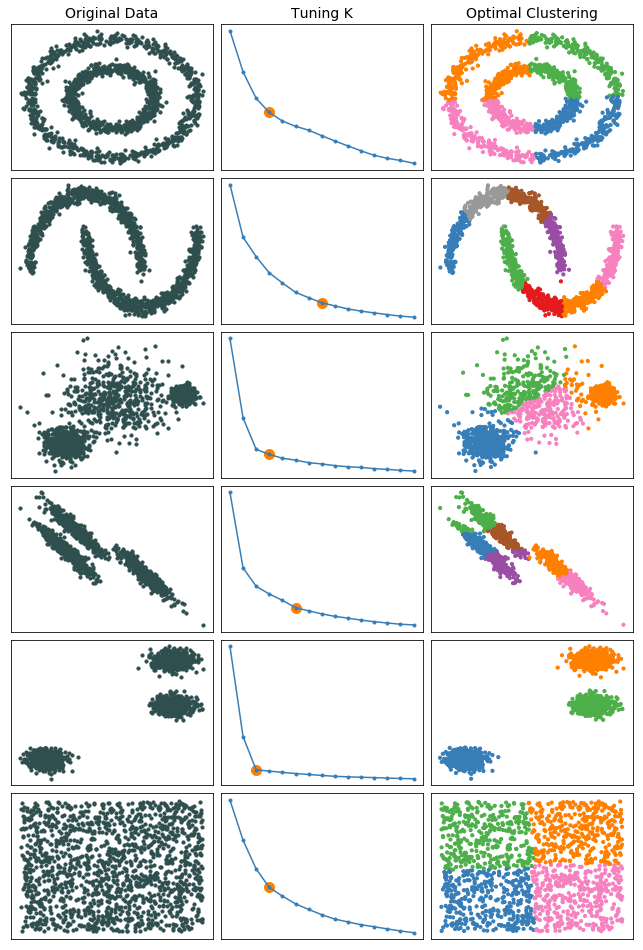

In [29]:
plt.figure(figsize=(9,40))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.04,hspace=.055)
plt.tight_layout()
plot_num = 1
#
for i_data,data in enumerate(datasets):
    plt.subplot(len(datasets)*3,3,plot_num)
    plt.scatter(data[:,0],data[:, 1],s=10,color="#2F4F4F")
    if i_data==0:
        plt.title("Original Data", size=14)
    plt.xticks(())
    plt.yticks(())
    #
    plot_num+=1
    plt.subplot(len(datasets)*3,3,plot_num)
    nclusters,y_pred,Ks,distortions,i=tuning_kmeans(data)
    plt.plot(Ks,distortions,"b.-",color='#377eb8')
    if i_data==0:
        plt.title("Tuning K", size=14)
    plt.xticks(())
    plt.yticks(())
    plt.scatter(Ks[i],distortions[i],s=100,color='#ff7f00')
    #
    plot_num+=1
    plt.subplot(len(datasets)*3,3,plot_num)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(data[:,0],data[:,1],s=10,color=colors[y_pred])
    if i_data==0:
        plt.title("Optimal Clustering", size=14)
    plt.xticks(())
    plt.yticks(())
    plot_num+=1
plt.show()